In [97]:
from pathlib import Path
import pickle
import itertools

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sns

import nb_utils

In [98]:
def features_for_dim(pd, dim):
	# b: birth, d: death
	b, d, _ = pd[pd[:,2] == dim].T
	if dim == 0:
		assert d[-1] == np.inf
		d[-1] = 1
	with np.errstate(invalid='ignore', divide='ignore'):
		return [
			mean_bd := np.c_[b, d].mean(axis=0),
			mean_bd**2,
			np.nan_to_num(1/mean_bd + np.log(mean_bd)), # fix divide by zero
			np.c_[b, d].std(axis=0),
			[np.mean(b - d)],
			[np.mean(b - d)**2],
			[np.mean((b + d) / 2)],
			[np.mean((b + d) / 2)**2],
		]

features = {
	'avg_birth_death': 2,
	'avg_birth_death_squared': 2,
	'avg_birth_death_inverted' : 2,
	'std_birth_death': 2,
	'avg_life': 1,
	'avg_life_squared': 1,
	'avg_half_life': 1,
	'avg_half_life_squared': 1
}

combinations = [*itertools.chain(*(
	itertools.combinations(features.keys(), r)
	for r in range(1, len(features) + 1)
))]

def features_all_dims(pd):
	arrs = [np.concatenate(features_for_dim(pd, dim)) for dim in (0, 1)]
	return np.vstack(arrs)

In [99]:
def get_labeled_data(task, files):
	gen_gaps = nb_utils.gen_gaps[task]
	pds = [*map(np.load, files)]
	X = np.stack([*map(features_all_dims, pds)])
	y = np.array([gen_gaps[f.name.split('.')[0]] for f in files])
	return X, y

In [100]:
def feature_mask(included):
	mask = np.tile(np.concatenate([
		np.full(length, 1 if feature in included else 0)
		for feature, length in features.items()
	]), 2)
	return np.where(mask)[0]

def run_experiment(X, y, tries, model_fn):
	results = np.empty((len(combinations), tries))
	splits = [*ShuffleSplit(tries, test_size=0.3).split(X)]
	for i, combo in enumerate(tqdm(combinations)):
		X_masked = X[:,:,np.where(feature_mask(combo))[0]]
		X_flattened = X_masked.reshape((len(X), -1))
		for j, (train, test) in enumerate(splits):
			reg = model_fn().fit(X_flattened[train], y[train])
			results[i, j] = reg.score(X_flattened[test], y[test])
	return results

In [65]:
def run_experiment(X, y, masks, tries, model_fn):
	X = X.reshape((len(X), -1))
	results = np.empty((len(masks), tries))
	splits = [*ShuffleSplit(tries, test_size=0.3).split(X)]
	for i, mask in enumerate(tqdm(masks)):
		X_masked = X[:,mask]
		for j, (train, test) in enumerate(splits):
			reg = model_fn().fit(X_masked[train], y[train])
			results[i, j] = reg.score(X_masked[test], y[test])
	return results

# files = [*nb_utils.get_files(1, sampler="Random")][0]
# X, y = get_labeled_data(1, files)
# masks = [np.repeat(m, X.shape[-1])*feature_mask(('std_birth_death', 'avg_life_squared', 'avg_half_life')) for m in [[1,0],[0,1],[1,1]]]
# res = run_experiment(X, y, masks, 1000, LinearRegression)

100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


In [66]:
res.mean(axis=1)

array([0.65769946, 0.31693156, 0.7314725 ])

In [67]:
masks

[array([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 0]),
 array([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 0])]

In [68]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def get_coeffs(X, y, tries, model_fn):
	model = make_pipeline(StandardScaler(), model_fn())
	X = X.reshape((len(X), -1))
	results = np.empty((X.shape[1]+1, tries))
	splits = [*ShuffleSplit(tries, test_size=0.3).split(X)]
	for i, (train, test) in enumerate(splits):
		reg = model.fit(X[train], y[train])[1]
		results[:,i] = np.insert(reg.coef_, 0, model.score(X[test], y[test]))
	return results

files = [*nb_utils.get_files(1, sampler="Random")][0]
res = get_coeffs(*get_labeled_data(1, files), 1000, LinearRegression)
r2s, coeffs = res[0], res[1:]
r2s.mean()

0.7631167224529388

In [69]:
feat = np.repeat(*zip(*features.items()))

In [21]:
coeffs.reshape((2,-1))

array([[ 0.        ,  0.        ,  0.        , ..., -0.29553614,
        -0.2843982 , -0.21688009],
       [-0.28986563, -0.87091244, -0.24271589, ...,  0.5108818 ,
         0.65689634,  0.43468028]])

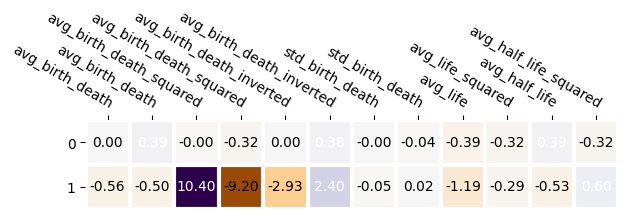

In [22]:
from importlib import reload
reload(nb_utils)

hm = coeffs.mean(axis=1).reshape((2,-1))
maxval = np.abs(hm).max()
norm = colors.Normalize(-maxval, maxval)
fig, ax = plt.subplots()
im, _ = nb_utils.heatmap(hm, [0, 1], feat,
						ax=ax, cmap='PuOr', norm=norm)
nb_utils.annotate_heatmap(im, threshold=0.3)
fig.tight_layout()

## Model performance
We look at the model performance for the model with the best performing selection of features (by average R2) and at the models incorporating all features

In [101]:
def extract_best(results, ):
	return max(results, key=np.mean)

def extract_all(results):
	return results[-1]

In [102]:
def results_for_sampler(task, files: list[Path]):
	task_name_date = files[0].parts[-4:-1]
	results_file = Path('results') / ("-".join(task_name_date) + '.npy')
	try:
		return np.load(results_file)
	except FileNotFoundError:
		print('Calculating', '/'.join(task_name_date))
		X, y = get_labeled_data(task, files)
		results = run_experiment(X, y, 1000, LinearRegression)
		np.save(results_file, results)
		return results

def results_all_samplers(task):
	samplers, files_task = zip(*nb_utils.get_files(task))
	results = np.array(
		[results_for_sampler(task, files_sampler) for files_sampler in files_task])
	return results, samplers

In [103]:
results, samplers = results_all_samplers(1)

pd.DataFrame({
	'All features': [np.mean(extract_all(res)) for res in results],
	'Best features': [np.mean(extract_best(res)) for res in results]
}, index=samplers)

,All features,Best features
AvgImportance,0.600350,0.719903
MaxImportance,0.723637,0.788833
Random,0.771025,0.815547
StratifiedKMeans20000,0.780958,0.824686
StratifiedRandom,0.746796,0.796928


In [104]:
feature_ix = {
	f: list(features.keys()).index(f) for f in features
}
counters = np.zeros((len(features)))
for exp in results[samplers.index('Random')].T:
	ixs = [feature_ix[f] for f in combinations[np.argmax(exp)]]
	counters[ixs] += 1


In [105]:
counters

array([387., 609., 859., 999., 512., 539., 501., 605.])

### KDE plots

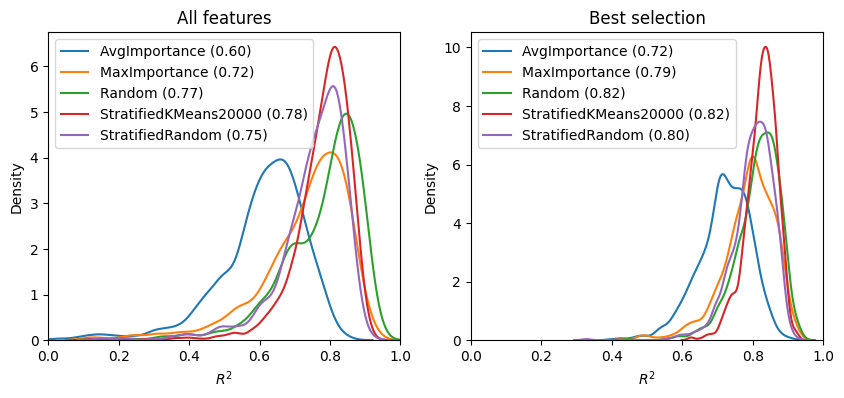

In [106]:
def plot_kdes(results, samplers=None, bw=0.2, figsize=(10, 4)):
	fig, axs = plt.subplots(1, 2, figsize=figsize)
	types = {'All features': extract_all, 'Best selection': extract_best}
	for ax, (title, extract) in zip(axs, types.items()):
		dists = [extract(results) for results in results]
		for i, dist in enumerate(dists):
			sampler = samplers[i] if samplers else None
			label = samplers[i] + f' ({dist.mean():.2f})' if samplers else None
			dist = dist[dist > 0]
			ax = sns.kdeplot(dist, ax=ax, bw_method=bw, label=label)
		if samplers:
			ax.legend()
		ax.set_xlabel('$R^2$')
		ax.set_xlim([0,1])
		ax.set_title(title)
	return fig, axs

plot_kdes(results, samplers)
plt.show()

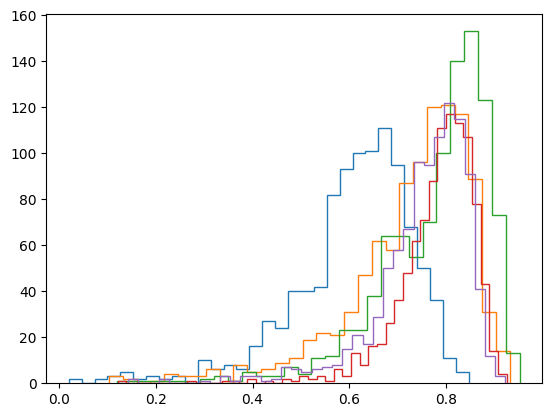

In [120]:
for res in results[:,-1]:
	plt.hist(res[res>=0], bins='auto', histtype='step')

In [116]:
np.mean([r[r>=0] for r in results[:,-1]], axis=2).T

/Users/otis/Documents/tfm/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


AxisError: axis 2 is out of bounds for array of dimension 1

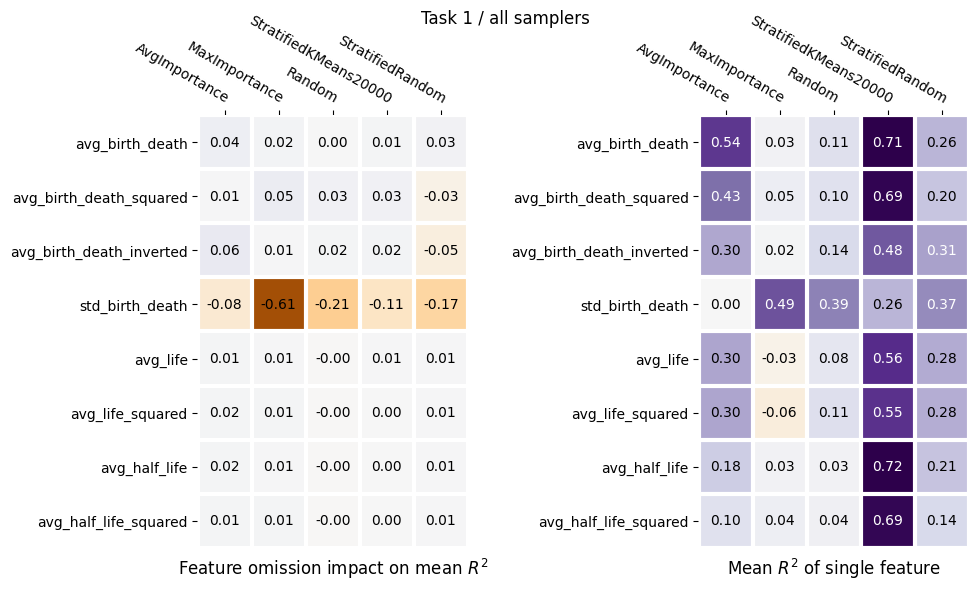

In [139]:
from importlib import reload
reload(nb_utils)

def heatmap_r2(results, samplers=None, wspace=0.6):
	one_removed_r2s = np.mean(results[:,-2:-len(features)-2:-1], axis=2)
	heatmaps = [
		one_removed_r2s - np.mean(results[:,[-1]], axis=2),
		np.mean(results[:,:len(features)], axis=2)
	]

	fig, axs = plt.subplots(1, 2, figsize=(10, 6))
	titles = [
		"Feature omission impact on mean $R^2$",
		"Mean $R^2$ of single feature"
	]

	maxval = np.abs(heatmaps).max()
	norm = colors.Normalize(-maxval, maxval)
	for i in 0, 1:
		im, _ = nb_utils.heatmap(heatmaps[i].T, features.keys(), samplers,
								ax=axs[i], cmap='PuOr', norm=norm)
		nb_utils.annotate_heatmap(im, threshold=0.3)
		axs[i].set_title(titles[i], y=-0.08)

	fig.tight_layout()
	plt.subplots_adjust(wspace=wspace)
	return fig, axs

fig, _ = heatmap_r2(results, samplers, wspace=0.6)
fig.suptitle('Task 1 / all samplers')
plt.show()

In [96]:
def best_selection_table(results, samplers=None):
	data = [
		[f in combinations[np.argmax(np.mean(res, 1))] for f in features]
		for res in results
	]
	data = dict(zip(samplers, data)) if samplers else np.transpose(data)
	return pd.DataFrame(data, index=features.keys()).replace({True: 'X', False: ''})

best_selection_table(results, samplers)

,AvgImportance,MaxImportance,Random,StratifiedKMeans20000,StratifiedRandom
avg_birth_death,,X,X,,
avg_birth_death_squared,X,,,X,X
avg_birth_death_inverted,,X,X,X,X
std_birth_death,X,X,X,X,X
avg_life,X,X,X,,X
avg_life_squared,,X,,,
avg_half_life,X,,,,
avg_half_life_squared,,X,X,X,X


In [134]:
results_random = np.array([
	results_for_sampler(1, files)
	for files in nb_utils.get_files(1, sampler='Random')
])

pd.DataFrame({
	'All features': [np.mean(extract_all(res)) for res in results_random],
	'Best features': [np.mean(extract_best(res)) for res in results_random]
})

,All features,Best features
0,0.771025,0.815547
1,0.821280,0.847617
2,0.757166,0.814416
3,0.716123,0.796214


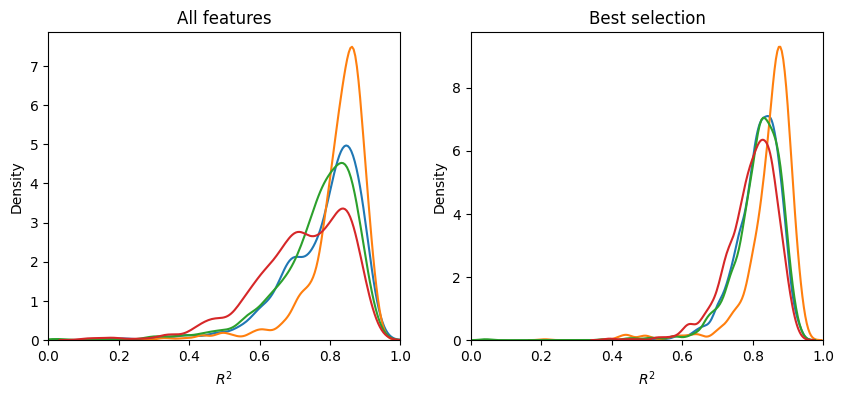

In [135]:
plot_kdes(results_random, bw=0.2)
plt.show()

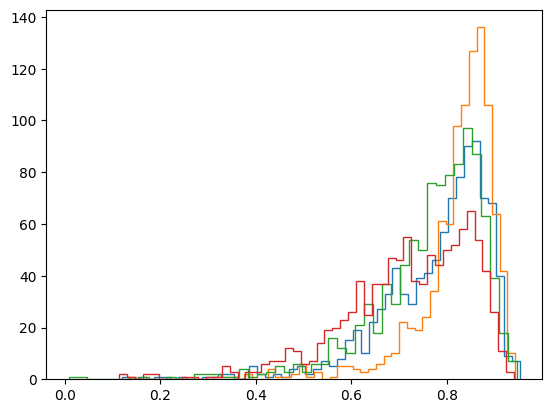

In [136]:
for res in np.array(results_random)[:,-1]:
	plt.hist(res[res>=0], bins=50, histtype='step')

In [137]:
best_selection_table(results_random)

,0,1,2,3
avg_birth_death,X,,,X
avg_birth_death_squared,,X,,
avg_birth_death_inverted,X,X,X,X
std_birth_death,X,X,X,X
avg_life,X,X,X,
avg_life_squared,,X,,
avg_half_life,,,X,
avg_half_life_squared,X,,X,X


In [144]:
results, samplers = results_all_samplers(2)
pd.DataFrame({
	'All features': [np.mean(extract_all(res)) for res in results],
	'Best features': [np.mean(extract_best(res)) for res in results]
}, index=samplers)

,All features,Best features
AvgImportance,0.804729,0.928600
MaxImportance,0.856164,0.906139
Random,0.305313,0.793242
StratifiedRandom,0.678292,0.802370


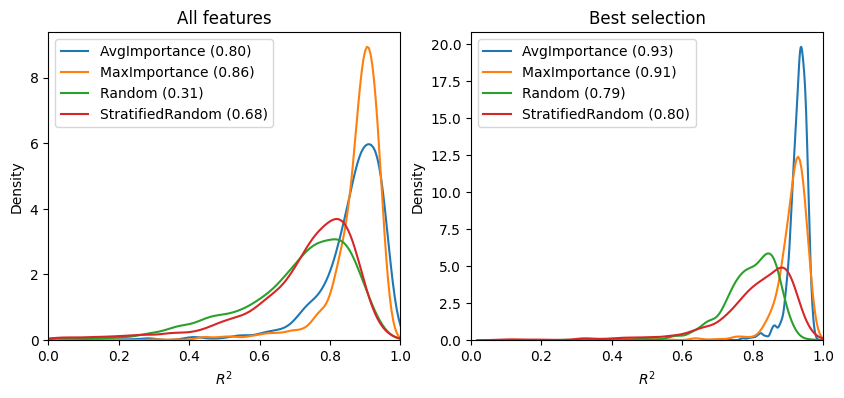

In [145]:
plot_kdes(results, samplers)
plt.show()

In [146]:
best_selection_table(results, samplers)

,AvgImportance,MaxImportance,Random,StratifiedRandom
avg_birth_death,,,,
avg_birth_death_squared,X,X,,
avg_birth_death_inverted,,X,,X
std_birth_death,,X,X,X
avg_life,X,,,X
avg_life_squared,,,X,X
avg_half_life,,X,X,X
avg_half_life_squared,,,,X


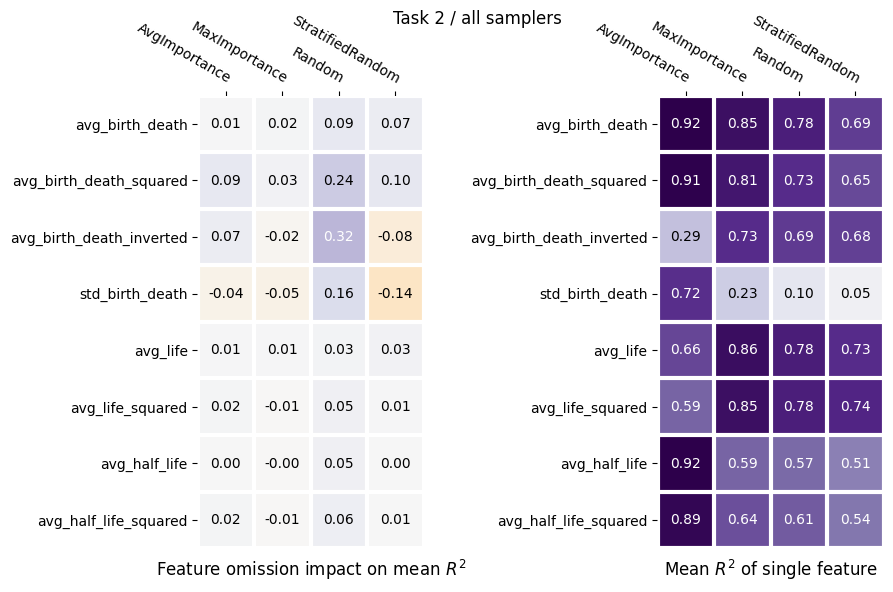

In [148]:
fig, _ = heatmap_r2(results, samplers, wspace=0.2)
fig.suptitle('Task 2 / all samplers')
plt.show()